In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pii-detection-removal-from-educational-data/sample_submission.csv
/kaggle/input/pii-detection-removal-from-educational-data/train.json
/kaggle/input/pii-detection-removal-from-educational-data/test.json
/kaggle/input/train-dataset/train.json
/kaggle/input/train-mix/train_mix.json


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import json
import random
import gc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
train_raw_data = json.load(open("/kaggle/input/pii-detection-removal-from-educational-data/train.json"))
train_raw_data.extend(json.load(open("/kaggle/input/train-mix/train_mix.json")))

In [5]:
# Display the first 20 elements
for i, item in enumerate(train_raw_data[:1]):
    print(f"Item {i}: {item}")

Item 0: {'document': 7, 'full_text': "Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla\n\nChallenge & selection\n\nThe tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.\n\nWhat exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1\n\nThis tool has many advantages:\n\n•  It is accessible to all and does not require significant material investment and can be done  quickly\n\n•  It is scalable\n\n•  It allows categorization and linking of information\n\n•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas\n\n•  It is suitable for all people and is easy to learn\n\n•  It is fun and enc

In [6]:
# Convert the list of dictionaries to a pandas DataFrame
train_df = pd.DataFrame(train_raw_data)
train_df.head(20)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal...","[O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUD..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
7,104,Storytelling The Path to Innovation\n\nDr Sak...,"[Storytelling, , The, Path, to, Innovation, \...","[True, False, True, True, True, False, False, ...","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
9,123,Gandhi Institute of Technology and Management ...,"[Gandhi, Institute, of, Technology, and, Manag...","[True, True, True, True, True, True, False, Tr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [7]:
train_df.describe()

,document,full_text,tokens,trailing_whitespace,labels
count,9499,9499,9499,9499,9499
unique,9499,9499,9499,9497,4556
top,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, False, True, True, False, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
freq,1,1,1,2,21


In [8]:
p = 0.02
p_test = 0
p_val = 0

context_size_piinonpii=10
context_size_pii=10
missing_word = '\0'

words_piinonpii = set()
words_pii = set()
words_piinonpii.add(missing_word)
words_pii.add(missing_word)

piinonpii_train_data = []
piinonpii_test_data = []
piinonpii_val_data = []

pii_train_data = []
pii_test_data = []
pii_val_data = []

In [9]:
pii_train, nonpii_train, pii_test, nonpii_test, pii_val, nonpii_val = 0, 0, 0, 0, 0, 0
for i in range(len(train_raw_data)):
    for j in range(len(train_raw_data[i]["tokens"])):
        if train_raw_data[i]["labels"][j] == 'O':
            if random.uniform(0, 1) <= p:
                prob = random.uniform(0, 1) 
                if  prob <= p_test:
                    piinonpii_test_data.append((i, j))
                    nonpii_test += 1
                elif prob <= p_test+p_val:
                    piinonpii_val_data.append((i, j))
                    nonpii_val += 1
                else:
                    for k in range(max(0, j-context_size_piinonpii), j+1):
                        words_piinonpii.add(train_raw_data[i]["tokens"][k].lower())
                    piinonpii_train_data.append((i, j))
                    nonpii_train += 1
        else:
            prob = random.uniform(0, 1)
            if  prob <= p_test:
                piinonpii_test_data.append((i, j))
                pii_test_data.append((i, j))
                pii_test += 1
            elif prob <= p_test + p_val:
                piinonpii_val_data.append((i, j))
                pii_val_data.append((i, j))
                pii_val += 1
            else:
                for k in range(max(0, j-context_size_piinonpii+1), j+1):
                    words_piinonpii.add(train_raw_data[i]["tokens"][k].lower())
                piinonpii_train_data.append((i, k))

                for k in range(max(0, j-context_size_pii+1), j+1):
                    words_pii.add(train_raw_data[i]["tokens"][k].lower())
                pii_train_data.append((i, k))
            
                pii_train += 1

In [10]:
vocabulary_piinonpiii = {word: i for i, word in enumerate(words_piinonpii)}
vocabulary_pii = {word: i for i, word in enumerate(words_pii)}

In [11]:
embedding_piinonpii = 30
lr_piinonpii = 0.001
threshold_piinonpii = 0.5

embedding_pii = 50
lr_pii = 0.001
idx_to_class = ["B-NAME_STUDENT", "B-EMAIL", "B-USERNAME", "B-ID_NUM", "B-PHONE_NUM", "B-URL_PERSONAL", "B-STREET_ADDRESS", "I-NAME_STUDENT", "I-EMAIL", "I-USERNAME", "I-ID_NUM", "I-PHONE_NUM", "I-URL_PERSONAL", "I-STREET_ADDRESS"]
class_to_idx = {idx_to_class[i]: i for i in range(len(idx_to_class))}

In [12]:
count = []
for document in train_raw_data:
    count.append(len(document["tokens"]))

Text(0.5, 1.0, 'Frequence of tokens in essays')

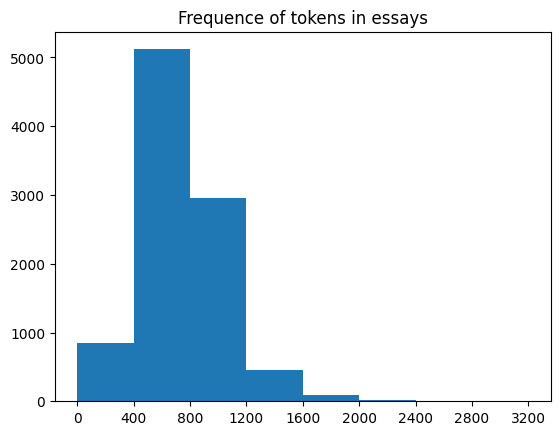

In [13]:
fig, ax = plt.subplots()

ax.hist(count, bins=range(0, 3500, 400))
ax.set_xticks(range(0, 3500, 400))
ax.set_title("Frequence of tokens in essays")

In [14]:
del words_piinonpii
del words_pii
gc.collect()

65

In [15]:
def createTensor(indices, context_size, vocabulary, pii=False, dataset=None, train=True):
    if dataset == None:
        dataset = train_raw_data
    i, j = indices

    data = torch.tensor([(vocabulary[dataset[i]["tokens"][k].lower()] if k >= 0 and dataset[i]["tokens"][k].lower() in vocabulary else vocabulary[missing_word]) for k in range(j-context_size+1, j+1)], dtype=torch.long)
    if not train: return data

    label = None
    if not pii:
        label = torch.tensor([0 if dataset[i]["labels"][j] == 'O' else 1], dtype=torch.float32)
    else:
        label = torch.tensor([class_to_idx[dataset[i]["labels"][j]]], dtype=torch.long)

    
    return (data, label)

In [16]:
class PIINonPIIDataset(Dataset):
    def __init__(self, type='train') -> None:
        super().__init__()
        self.data = piinonpii_train_data if type=='train' else (piinonpii_val_data if type=='val' else piinonpii_test_data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if index >= self.__len__():
            raise Exception("Out of bounds")
        
        return createTensor(self.data[index], context_size_piinonpii, vocabulary_piinonpiii)

class PIIDataset(Dataset):
    def __init__(self, type='train') -> None:
        super().__init__()
        self.data = pii_train_data if type=='train' else (pii_val_data if type=='val' else pii_test_data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if index >= self.__len__():
            raise Exception("Out of bounds")
        
        return createTensor(self.data[index], context_size_pii, vocabulary_pii, pii=True)

In [17]:
class NGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, output_size) -> None:
        super(NGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layers = nn.Sequential(nn.Flatten(), nn.Linear(context_size*embedding_dim, 128), nn.ReLU(), nn.Linear(128, output_size))

    def forward(self, x):
        embed = self.embedding(x)
        return self.layers(embed)

    def type(self):
        return "normal"

In [18]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_sizes) -> None:
        super(RNN, self).__init__()
        self.hidden_size = hidden_sizes

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        hidden_layers = [nn.Linear(embedding_dim, hidden_sizes[0])]
        hidden_layers.extend([nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))])
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.prev_hidden_layers = nn.Sequential(*[nn.Linear(hs, hs) for hs in hidden_sizes])
        
    
    def forward(self, x, hidden):
        embed = self.embedding(x)
        hidden_outputs = []
        for i in range(len(self.hidden_layers)):
            hidden_outputs.append(F.tanh(self.hidden_layers[i](embed if len(hidden_outputs) == 0 else hidden_outputs[-1]) + self.prev_hidden_layers[i](hidden[i])))
        output = hidden_outputs[-1]
        return output, hidden_outputs

    def init_hidden(self, batch_size):
        return [torch.zeros(batch_size, hs, device=device) for hs in self.hidden_size]

    def type(self):
        return "rnn"

In [19]:
class LSTMMOdel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_sizes):
        super(LSTMMOdel, self).__init__()
        self.hidden_sizes = hidden_sizes

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        hidden_layers = [nn.LSTM(embedding_dim, hidden_sizes[0], batch_first=True)]
        hidden_layers.extend([nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], batch_first=True) for i in range(1, len(hidden_sizes))])
        self.hidden_layers = nn.Sequential(*hidden_layers)
    
    def forward(self, x, h, c):
        x = self.embedding(x)
        hn, cn = [], []
        for i in range(len(self.hidden_sizes)):
            x, (ht, ct) = self.hidden_layers[i](x, (h[i], c[i]))
            hn.append(ht)
            cn.append(ct)
        return x[:, -1, :], hn, cn

    def init_hidden(self, batch_size):
        return [torch.zeros(1, batch_size, hs, device=device) for hs in self.hidden_sizes], [torch.zeros(1, batch_size, hs, device=device) for hs in self.hidden_sizes]

    def type(self):
        return "lstm"

In [20]:
def train_model(model, optimizer, loss_fn, data, epochs=10, batch_size=64, pii=False, val_data=None):
    model_type = model.type()
    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    for epoch in range(epochs):
        loader = DataLoader(data, shuffle=True, batch_size=batch_size)
        train_avg_loss, train_avg_acc = 0, 0
        for index, (input_data, label) in enumerate(loader):
            input_data = input_data.to(device=device)
            label = label.to(device=device)
            optimizer.zero_grad()

            if model_type == 'rnn':
                hidden = model.init_hidden(input_data.shape[0])
                for i in range(input_data.shape[1]):
                    temp = input_data[:, i]
                    output, hidden = model(temp, hidden)
            elif model_type == 'normal':
                output = model(input_data)
            else:
                h, c = model.init_hidden(input_data.shape[0])
                output, h, c = model(input_data, h, c)

            if pii: label = label.squeeze()
            loss = loss_fn(output, label)

            predictions = torch.argmax(output, dim=1) if pii else torch.where(output >= threshold_piinonpii, 1, 0)
            accuracy = ((torch.sum(predictions == label).item())/(label.shape[0]))*100
            
            train_avg_acc += accuracy
            train_avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        

        
        train_avg_loss /= len(loader)
        train_avg_acc /= len(loader)
        train_accs.append(train_avg_acc)
        train_losses.append(train_avg_loss)
        print("Train Epoch %s: Loss: %s, Accuracy:%s%%"%(epoch, train_avg_loss, train_avg_acc))

        if val_data == None: continue

        val_avg_loss, val_avg_acc = 0, 0
        loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
        for index, (input_data, label) in enumerate(loader):
            input_data = input_data.to(device=device)
            label = label.to(device=device)

            if model_type == 'rnn':
                hidden = model.init_hidden(input_data.shape[0])
                for i in range(input_data.shape[1]):
                    temp = input_data[:, i]
                    output, hidden = model(temp, hidden)
            elif model_type == 'normal':
                output = model(input_data)
            else:
                h, c = model.init_hidden(input_data.shape[0])
                output, h, c = model(input_data, h, c)

            if pii: label = label.squeeze()
            loss = loss_fn(output, label)

            predictions = torch.argmax(output, dim=1) if pii else torch.where(output >= threshold_piinonpii, 1, 0)
            accuracy = ((torch.sum(predictions == label).item())/(label.shape[0]))*100
            
            val_avg_acc += accuracy
            val_avg_loss += loss.item()
        
        val_avg_loss /= len(loader)
        val_avg_acc /= len(loader)
        val_accs.append(val_avg_acc)
        val_losses.append(val_avg_loss)
        print("Val Epoch %s: Loss: %s, Accuracy:%s%%"%(epoch, val_avg_loss, val_avg_acc))

    if val_data != None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(range(epochs), train_losses, color='blue')
        ax[0].plot(range(epochs), val_losses, color='orange')
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend(["Training", "Validation"])
        ax[0].set_xticks(range(epochs), labels=range(1, epochs+1))

        ax[1].plot(range(epochs), train_accs, color='blue')
        ax[1].plot(range(epochs), val_accs, color='orange')
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy(%)")
        ax[1].legend(["Training", "Validation"])
        ax[1].set_ylim([0, 100])
        ax[1].set_xticks(range(epochs), labels=range(1, epochs+1))
        fig.tight_layout()

In [21]:
def real_test_model(model1, model2):
    model_type1, model_type2 = model1.type(), model2.type()
    test_data = json.load(open("/kaggle/input/pii-detection-removal-from-educational-data/test.json"))
    file = open("submission.csv", "w")
    file.write("row_id,document,token,label")
    preds = 0
    for i in range(len(test_data)):
        for j in range(len(test_data[i]["tokens"])):
            input1 = createTensor((i, j), context_size_piinonpii, vocabulary_piinonpiii, False, test_data, False)
            input1 = input1.to(device=device)
            input1.unsqueeze_(0)

            if model_type1 == 'rnn':
                hidden = model1.init_hidden(1)
                for k in range(input1.shape[1]):
                    pred1, hidden = model1(input1[:, k], hidden)
            elif model_type1 == 'normal':
                pred1 = model1(input1)
            else:
                h, c = model1.init_hidden(1)
                pred1, h, c = model1(input1, h, c)

            if pred1.item() < threshold_piinonpii: continue
            
            input2 = createTensor((i, j), context_size_pii, vocabulary_pii, True, test_data, False)
            input2 = input2.to(device=device)
            input2.unsqueeze_(0)

            if model_type2 == 'rnn':
                hidden = model2.init_hidden(1)
                for k in range(input2.shape[1]):
                    pred2, hidden = model2(input2[:, k], hidden)
            elif model_type2 == 'normal':
                pred2 = model2(input2)
            else:
                h, c = model2.init_hidden(1)
                pred2, h, c = model2(input2, h, c)
            
            label = torch.argmax(pred2).item()
            file.write("\n%s,%s,%s,%s"%(preds, test_data[i]["document"], j, idx_to_class[label]))
            preds += 1
    file.close()

In [22]:
ds_piinonpii = PIINonPIIDataset()
model_piinonpii = LSTMMOdel(len(vocabulary_piinonpiii), embedding_piinonpii, [32, 16, 1]).to(device=device)#NGramModel(len(vocabulary_piinonpiii), embedding_piinonpii, context_size_piinonpii, 1).to(device=device) #RNN(len(vocabulary_piinonpiii), embedding_piinonpii, [96, 64, 32], 1) 
loss_fn_piinonpii = nn.BCEWithLogitsLoss(reduction='mean')
optimizer_piinonpii = torch.optim.Adam(model_piinonpii.parameters(), lr_piinonpii)

In [23]:
train_model(model_piinonpii, optimizer_piinonpii, loss_fn_piinonpii, ds_piinonpii, epochs=20, batch_size=64, pii=False)

Train Epoch 0: Loss: 0.3811413543545848, Accuracy:93.05600952558835%
Train Epoch 1: Loss: 0.34243245683902673, Accuracy:97.15502966868769%
Train Epoch 2: Loss: 0.33217739173846766, Accuracy:98.32574854170858%
Train Epoch 3: Loss: 0.3276746914174782, Accuracy:98.81850557455246%
Train Epoch 4: Loss: 0.32496050869657067, Accuracy:99.09296787448636%
Train Epoch 5: Loss: 0.3237198751098325, Accuracy:99.2416704979742%
Train Epoch 6: Loss: 0.32263546386092823, Accuracy:99.33227493462832%
Train Epoch 7: Loss: 0.32206105694959625, Accuracy:99.3999813223758%
Train Epoch 8: Loss: 0.32126130550532006, Accuracy:99.47235711617482%
Train Epoch 9: Loss: 0.32085503080597466, Accuracy:99.52300221258011%
Train Epoch 10: Loss: 0.3203307752917407, Accuracy:99.56691258871872%
Train Epoch 11: Loss: 0.319742387851584, Accuracy:99.62294546133732%
Train Epoch 12: Loss: 0.3195778334434682, Accuracy:99.63753735524841%
Train Epoch 13: Loss: 0.3193108842116396, Accuracy:99.66088438550617%
Train Epoch 14: Loss: 0.31

In [24]:
ds_pii = PIIDataset()
model_pii = LSTMMOdel(len(vocabulary_pii), embedding_pii, [256, 128, 64, 32, len(idx_to_class)]).to(device=device)
loss_fn_pii = nn.CrossEntropyLoss(reduction="mean")
optimizer_pii = torch.optim.Adam(model_pii.parameters(), lr_pii)

In [25]:
train_model(model_pii, optimizer_pii, loss_fn_pii, ds_pii, epochs=30, batch_size=64, pii=True)

Train Epoch 0: Loss: 1.8217156975474578, Accuracy:45.808498896247244%
Train Epoch 1: Loss: 1.5452044831206466, Accuracy:57.22337196467991%
Train Epoch 2: Loss: 1.4281583977061392, Accuracy:62.3385761589404%
Train Epoch 3: Loss: 1.355213604752328, Accuracy:66.4459161147903%
Train Epoch 4: Loss: 1.3182500685024472, Accuracy:71.61630794701986%
Train Epoch 5: Loss: 1.2807074082608254, Accuracy:85.39321192052981%
Train Epoch 6: Loss: 1.2207812284002242, Accuracy:92.13576158940397%
Train Epoch 7: Loss: 1.1820830246207468, Accuracy:93.77690397350993%
Train Epoch 8: Loss: 1.1627676297497276, Accuracy:94.62541390728477%
Train Epoch 9: Loss: 1.1447590223737636, Accuracy:95.54359823399558%
Train Epoch 10: Loss: 1.131475985444934, Accuracy:96.27138520971303%
Train Epoch 11: Loss: 1.126717965860767, Accuracy:96.49903421633555%
Train Epoch 12: Loss: 1.1168530305752955, Accuracy:97.08402317880795%
Train Epoch 13: Loss: 1.1135265327184143, Accuracy:97.23371964679912%
Train Epoch 14: Loss: 1.1081959772

In [26]:
real_test_model(model_piinonpii, model_pii)